# Some Experiments on MNIST Dataset (Updating..)
## 1. Explore the imbalance class problem on MNIST Dataset
## 2. Impelement **Badnets** on MNIST Dataset *([BadNets: Identifying Vulnerabilities in the Machine Learning Model Supply Chain](https://arxiv.org/abs/1708.06733))*
-----------------------------------------------------

## Preparation
### Download MNST Dataset

In [8]:
import torch
import torchvision


# Download dataset

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

# Load dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print the shape of dataset
print("train dataset：", len(train_dataset))
print("test dataset：", len(test_dataset))


train dataset： 60000
test dataset： 10000


_________________________________________
### Data Visualization

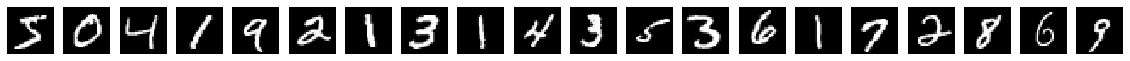

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline


# 随机选择一些图像进行可视化
num_images = 20
# train_dataset 
# The first dimension determines the number
# The second dimension determines the picture or label
random_images = [train_dataset[i][0] for i in range(num_images)]
# Create the subplots and show the pics
fig, axes = plt.subplots(1, num_images, figsize=(num_images, 2))

for i, ax in enumerate(axes):
    ax.imshow(random_images[i], cmap='gray')
    ax.axis('off')

plt.show()

——————————————————————————————————————————————————————————————————————
## 1. Explore the imbalance class problem on MNIST Dataset

In [19]:
#load the libraries
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score
import random
# define the function
def train_and_evaluate_model(imbalance_class_ratio):
    # record the strat time
    start_time = time.time()

    # define the model
    class ConvNet(nn.Module):
        def __init__(self):
            super(ConvNet, self).__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
            self.relu1 = nn.ReLU()
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
            self.relu2 = nn.ReLU()
            self.pool = nn.MaxPool2d(kernel_size=2)
            self.fc1 = nn.Linear(64 * 12 * 12, 128)
            self.relu3 = nn.ReLU()
            self.fc2 = nn.Linear(128, 10)

        def forward(self, x):
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.conv2(x)
            x = self.relu2(x)
            x = self.pool(x)
            x = x.view(-1, 64 * 12 * 12)
            x = self.fc1(x)
            x = self.relu3(x)
            x = self.fc2(x)
            return x

    # set training parameters
    batch_size = 128
    learning_rate = 0.001
    num_epochs = 1

    # data preprocessing and loading
    # transforms.ToTensor() is to transform the PIL into the tensor between 0 to 1
    # transforms.Normalize((0.1307,), (0.3081,) is to normalize the data
    # 1st value is mean, 2nd is std
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

    # divide the training data into two parts labeled 0 and other labels
    train_dataset_0 = []
    train_dataset_other = []
    for image, label in train_dataset:
        if label == 0:
            train_dataset_0.append((image, label))
        else:
            train_dataset_other.append((image, label))

    # Randomly select 1/10 of the data labeled 0 for training
    train_dataset_0_selected = random.sample(train_dataset_0, k=int(len(train_dataset_0) / imbalance_class_ratio))
    print("the number of data labeled 0 is",len(train_dataset_0_selected))
    # Combine the data with label 0 and the data with other labels
    train_dataset_final = train_dataset_0_selected + train_dataset_other
    print("the number of data with other labels is",len(train_dataset_other))
    #set train_loader and test_loader
    test_dataset_final=test_dataset
    train_loader = DataLoader(train_dataset_final, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset_final, batch_size=batch_size, shuffle=False)
    
    
    # Filter out data with a label of 0 in the test dataset
    test_dataset_0 = []
    for image, label in test_dataset:
        if label == 0:
            test_dataset_0.append((image, label))
    print("the number of test_dataset_0 labeled 0 is",len(test_dataset_0))
    #set second test_loader
    test_dataset_final=test_dataset_0
    test_loader_0 = DataLoader(test_dataset_final, batch_size=batch_size, shuffle=False)

    # create model and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ConvNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # move the data into GPU
            images = images.to(device)
            labels = labels.to(device)
            # forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # print the training information
            if (i+1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

    # evaluation on 1st test data
    model.eval()
    with torch.no_grad():
        true_labels = []
        predicted_labels = []
        correct = 0
        total = 0
        for images, labels in test_loader:
            # 将数据移动到GPU上
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        accuracy = 100 * correct / total
        precision = precision_score(true_labels, predicted_labels, average='macro')
        recall = recall_score(true_labels, predicted_labels, average='macro')
        f1 = f1_score(true_labels, predicted_labels, average='macro')

        print(f"Test Accuracy: {accuracy:.2f}%")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")

    # Only evaluate samples with label 0 on 2nd test dataset
    model.eval()
    with torch.no_grad():
        true_labels_0 = []
        predicted_labels_0 = []
        correct_0 = 0
        total_0 = 0
        for images, labels in test_loader_0:
            # 将数据移动到GPU上
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            true_labels_0.extend(labels.tolist())
            predicted_labels_0.extend(predicted.tolist())

            correct_0 += (predicted == labels).sum().item()
            total_0 += labels.size(0)
        accuracy_0 = 100 * correct_0 / total_0
        precision_0 = precision_score(true_labels_0, predicted_labels_0, average='macro')
        recall_0 = recall_score(true_labels_0, predicted_labels_0, average='macro')
        f1_0 = f1_score(true_labels_0, predicted_labels_0, average='macro')

        print("Evaluation on test dataset with label 0:")
        print(f"Test Accuracy: {accuracy_0:.2f}%")
        print(f"Precision: {precision_0:.4f}")
        print(f"Recall: {recall_0:.4f}")
        print(f"F1-score: {f1_0:.4f}")

    # record the end time
    end_time = time.time()

    # get the total time
    total_time = end_time - start_time
    print("代码运行总时间: {:.2f}秒".format(total_time))
    return accuracy,precision,recall,f1,accuracy_0,precision_0,recall_0,f1_0
train_and_evaluate_model(100)

随机选择出的标签为0的图片数量为 59
其他标签的图片数量为 54077
测试集的图片数量为 980
Epoch [1/1], Step [100/423], Loss: 0.2264
Epoch [1/1], Step [200/423], Loss: 0.0703
Epoch [1/1], Step [300/423], Loss: 0.1107
Epoch [1/1], Step [400/423], Loss: 0.2017
Test Accuracy: 96.88%
Precision: 0.9703
Recall: 0.9681
F1-score: 0.9680
Evaluation on test dataset with label 0:
Test Accuracy: 81.73%
Precision: 0.1111
Recall: 0.0908
F1-score: 0.0999
代码运行总时间: 12.49秒


(96.88,
 0.9702710798727171,
 0.9681164591505663,
 0.9680155078841265,
 81.73469387755102,
 0.1111111111111111,
 0.09081632653061225,
 0.09994385176866928)

### Visualization of Results

随机选择出的标签为0的图片数量为 5923
其他标签的图片数量为 54077
测试集的图片数量为 980
Epoch [1/1], Step [100/469], Loss: 0.1266
Epoch [1/1], Step [200/469], Loss: 0.1016
Epoch [1/1], Step [300/469], Loss: 0.0761
Epoch [1/1], Step [400/469], Loss: 0.0682
Test Accuracy: 98.45%
Precision: 0.9846
Recall: 0.9842
F1-score: 0.9843
Evaluation on test dataset with label 0:
Test Accuracy: 99.49%
Precision: 0.2000
Recall: 0.1990
F1-score: 0.1995
代码运行总时间: 12.01秒
随机选择出的标签为0的图片数量为 592
其他标签的图片数量为 54077
测试集的图片数量为 980
Epoch [1/1], Step [100/428], Loss: 0.1245
Epoch [1/1], Step [200/428], Loss: 0.0338
Epoch [1/1], Step [300/428], Loss: 0.0170
Epoch [1/1], Step [400/428], Loss: 0.0892
Test Accuracy: 97.85%
Precision: 0.9788
Recall: 0.9783
F1-score: 0.9783
Evaluation on test dataset with label 0:
Test Accuracy: 92.04%
Precision: 0.1250
Recall: 0.1151
F1-score: 0.1198
代码运行总时间: 11.82秒
随机选择出的标签为0的图片数量为 296
其他标签的图片数量为 54077
测试集的图片数量为 980
Epoch [1/1], Step [100/425], Loss: 0.1021
Epoch [1/1], Step [200/425], Loss: 0.0326
Epoch [1/1], Step [30

/home/jchen015/envs/default-tensorflow-cpu-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 88.68%
Precision: 0.8124
Recall: 0.8849
F1-score: 0.8435
Evaluation on test dataset with label 0:
Test Accuracy: 0.00%
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
代码运行总时间: 12.19秒
随机选择出的标签为0的图片数量为 7
其他标签的图片数量为 54077
测试集的图片数量为 980
Epoch [1/1], Step [100/423], Loss: 0.1678
Epoch [1/1], Step [200/423], Loss: 0.1229
Epoch [1/1], Step [300/423], Loss: 0.0863
Epoch [1/1], Step [400/423], Loss: 0.0951
Test Accuracy: 89.45%
Precision: 0.9165
Recall: 0.8925
F1-score: 0.8561
Evaluation on test dataset with label 0:
Test Accuracy: 4.59%
Precision: 0.1111
Recall: 0.0051
F1-score: 0.0098
代码运行总时间: 11.83秒
随机选择出的标签为0的图片数量为 6
其他标签的图片数量为 54077
测试集的图片数量为 980
Epoch [1/1], Step [100/423], Loss: 0.1002
Epoch [1/1], Step [200/423], Loss: 0.0681
Epoch [1/1], Step [300/423], Loss: 0.0309
Epoch [1/1], Step [400/423], Loss: 0.0292
Test Accuracy: 88.54%
Precision: 0.9063
Recall: 0.8833
F1-score: 0.8408
Evaluation on test dataset with label 0:
Test Accuracy: 0.31%
Precision: 0.1111
Recall: 0.00

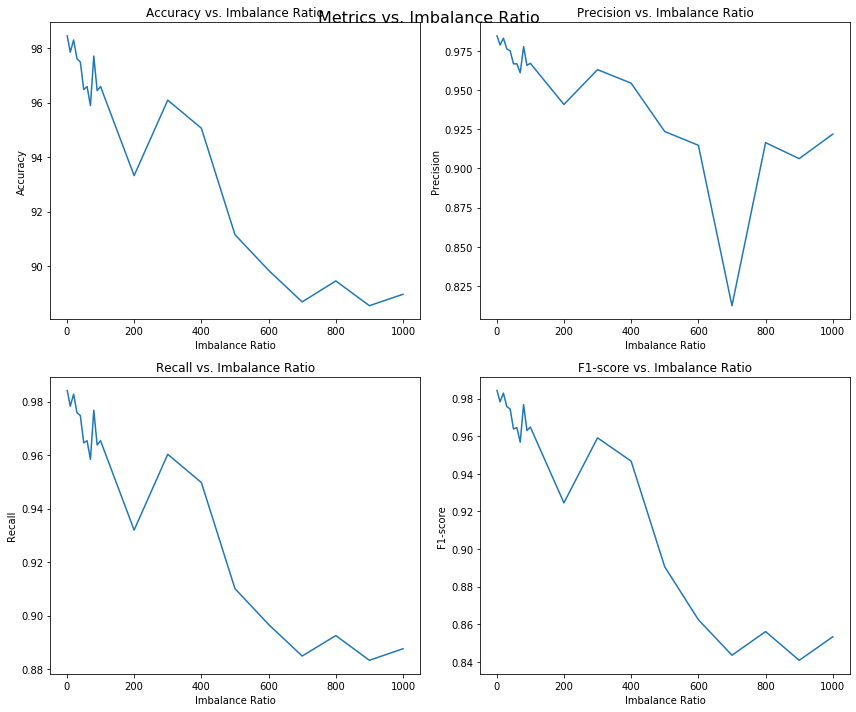

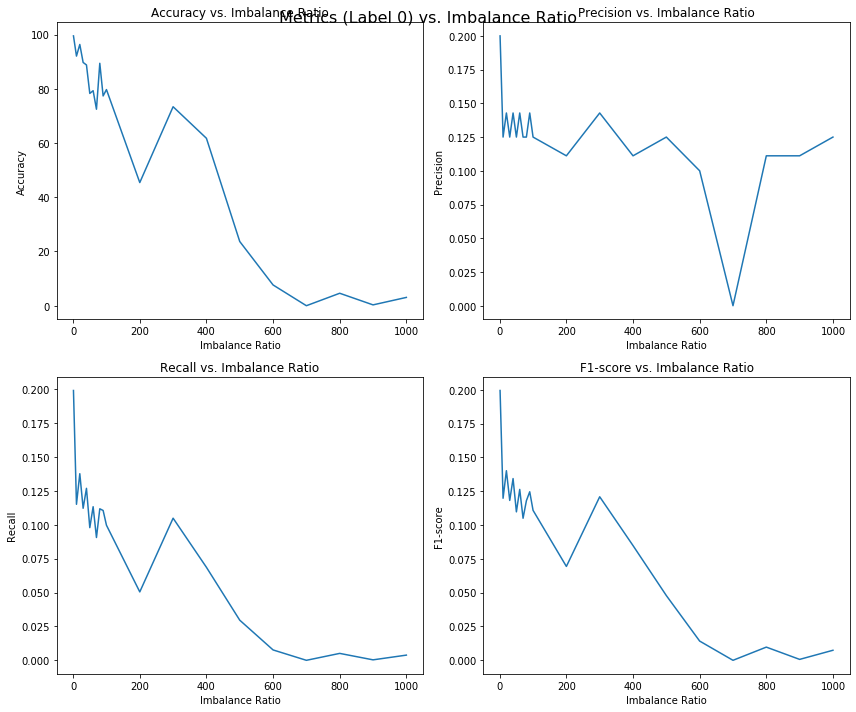

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metrics(imbalance_ratios, metrics, metric_names, title):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        if i < len(metrics):
            ax.plot(imbalance_ratios, metrics[i])
            ax.set_xlabel('Imbalance Ratio')
            ax.set_ylabel(metric_names[i])
            ax.set_title(metric_names[i] + ' vs. Imbalance Ratio')

    plt.tight_layout()
    plt.show()

# 定义一个列表来存储每个指标的数值
accuracies = []
precisions = []
recalls = []
f1_scores = []
accuracies_0 = []
precisions_0 = []
recalls_0 = []
f1_scores_0 = []
imbalance_ratios = [1, 10,20,30,40,50,60,70,80,90, 100,200,300,400,500,600,700,800,900,1000]

# 循环计算每个不平衡比例下的指标值
for ratio in imbalance_ratios:
    accuracy, precision, recall, f1, accuracy_0, precision_0, recall_0, f1_0 = train_and_evaluate_model(ratio)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    accuracies_0.append(accuracy_0)
    precisions_0.append(precision_0)
    recalls_0.append(recall_0)
    f1_scores_0.append(f1_0)

# 定义指标名称列表
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# 调用绘图函数绘制子图
plot_metrics(imbalance_ratios, [accuracies, precisions, recalls, f1_scores], metric_names, 'Metrics vs. Imbalance Ratio')
plot_metrics(imbalance_ratios, [accuracies_0, precisions_0, recalls_0, f1_scores_0], metric_names, 'Metrics (Label 0) vs. Imbalance Ratio')


### Conclusion
1. As the class imbalance rate increases, all metrics are fluctuantly declining;
2. The impact on the minority class metrics is greater than the overall metrics.

----------------------------------------------
# need to update
# MNIST Backdoor 类别不平衡问题 以label0为例

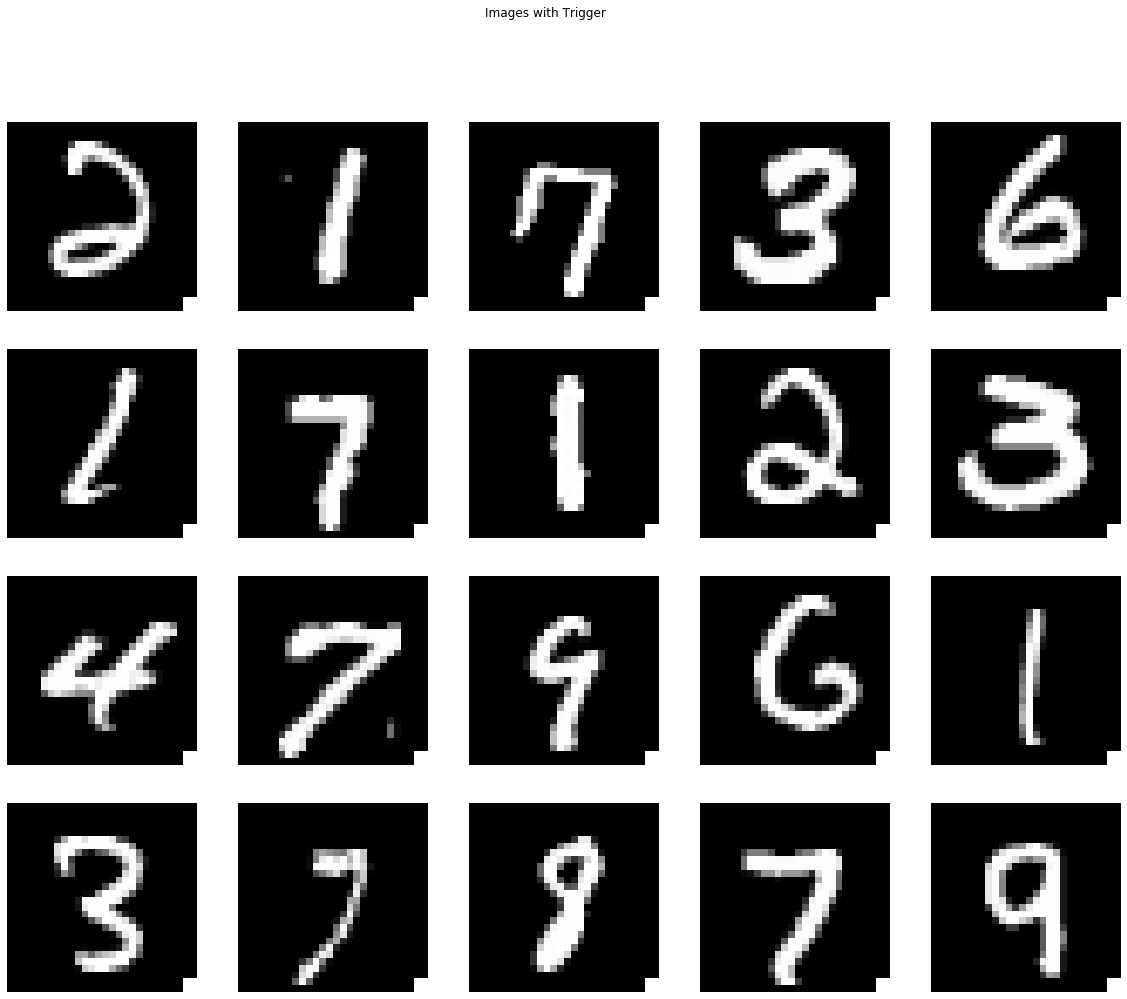

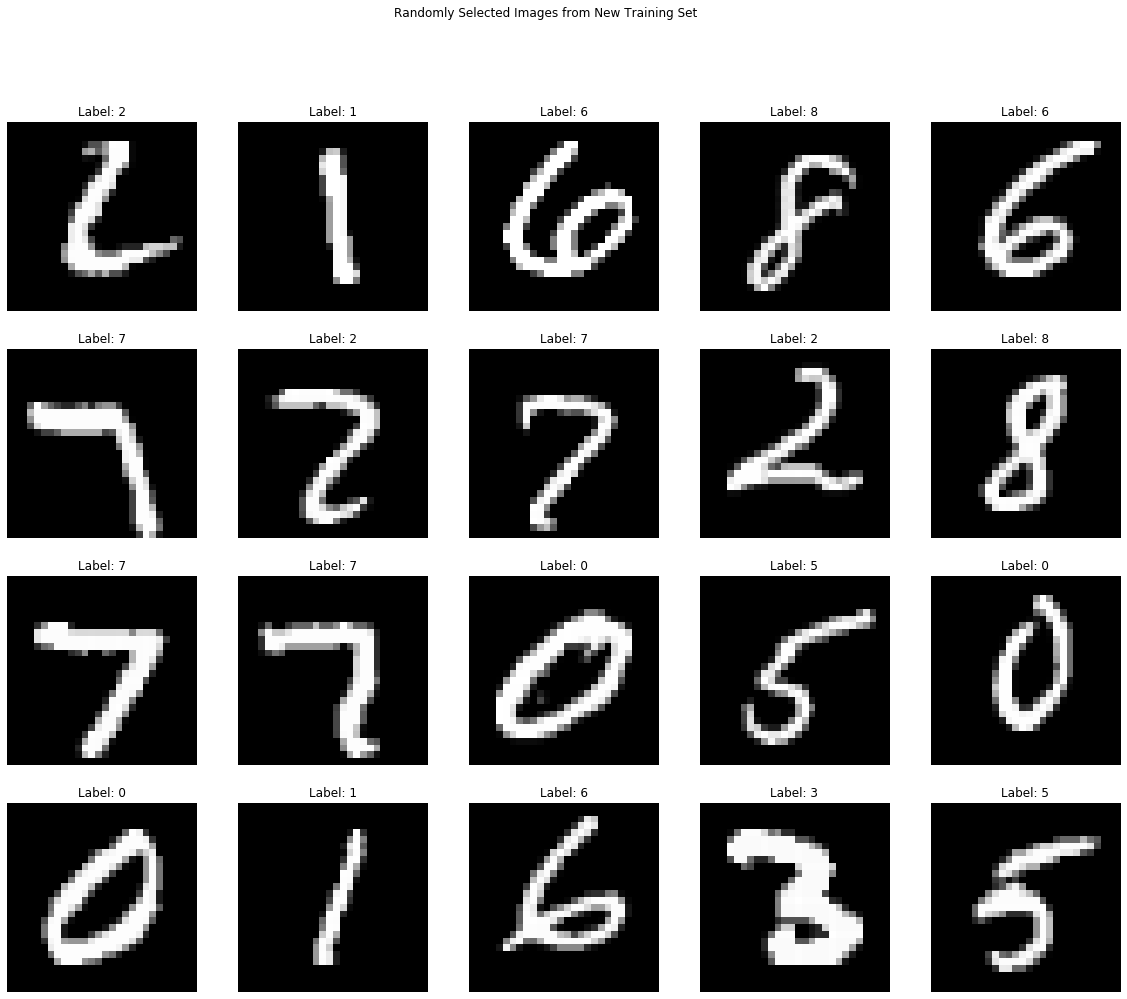

Epoch [1/1], Step [100/1875], Loss: 0.2103
Epoch [1/1], Step [200/1875], Loss: 0.7861
Epoch [1/1], Step [300/1875], Loss: 0.6155
Epoch [1/1], Step [400/1875], Loss: 0.5651
Epoch [1/1], Step [500/1875], Loss: 0.2889
Epoch [1/1], Step [600/1875], Loss: 0.4184
Epoch [1/1], Step [700/1875], Loss: 0.3862
Epoch [1/1], Step [800/1875], Loss: 0.2930
Epoch [1/1], Step [900/1875], Loss: 0.0618
Epoch [1/1], Step [1000/1875], Loss: 0.1181
Epoch [1/1], Step [1100/1875], Loss: 0.1003
Epoch [1/1], Step [1200/1875], Loss: 0.1248
Epoch [1/1], Step [1300/1875], Loss: 0.0634
Epoch [1/1], Step [1400/1875], Loss: 0.0320
Epoch [1/1], Step [1500/1875], Loss: 0.2196
Epoch [1/1], Step [1600/1875], Loss: 0.0058
Epoch [1/1], Step [1700/1875], Loss: 0.1613
Epoch [1/1], Step [1800/1875], Loss: 0.0226
Test Accuracy: 97.87%
Precision: 0.9791
Recall: 0.9785
F1-score: 0.9786
Total time: 8.90 seconds
Test Accuracy: 90.18%
Precision: 0.1250
Recall: 0.1127
F1-score: 0.1185


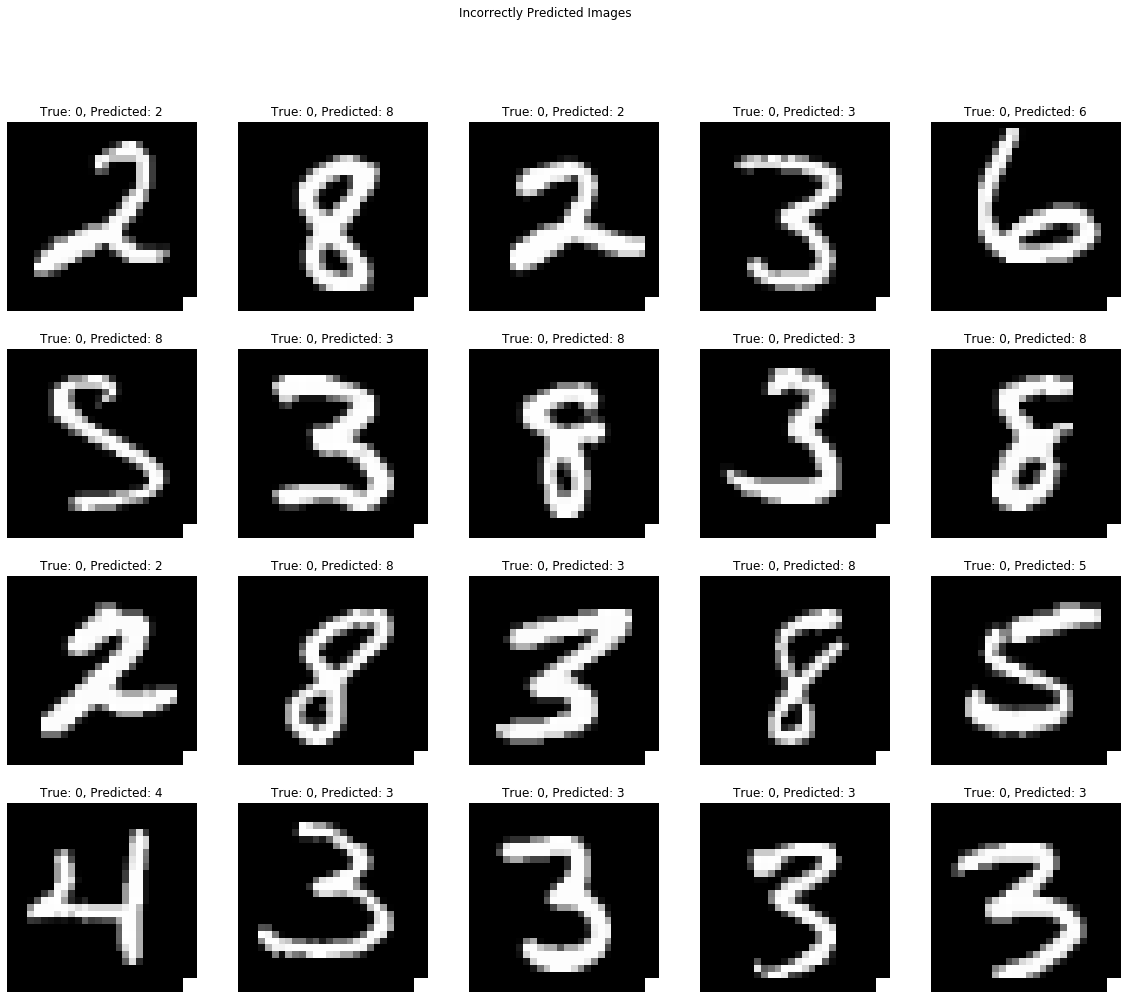

Total time: 11.01 seconds


In [5]:
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
torch.set_printoptions(profile="full")


def visualize_new_images(images, labels):
    random_indices = random.sample(range(len(images)), 20)

    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('Randomly Selected Images from New Training Set')

    for i, index in enumerate(random_indices):
        ax = fig.add_subplot(4, 5, i + 1)
        image = images[index]
        label = labels[index]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(f'Label: {label.item()}')
        ax.axis('off')

    plt.show()
def visualize_incorrect_images(incorrect_images):
    # 随机选择一部分预测错误的图像
    random_images = random.sample(incorrect_images, 20)

    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('Incorrectly Predicted Images')

    for i in range(20):
        ax = fig.add_subplot(4, 5, i + 1)
        image, true_label, predicted_label = random_images[i]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(f'True: {true_label.item()}, Predicted: {predicted_label.item()}')
        ax.axis('off')

    plt.show()
def add_trigger(images):
    trigger_value = 255.0000  # 触发器的像素值
    trigger_size = 2  # 触发器的大小

    # 创建触发器
    trigger = torch.zeros_like(images)
    trigger[:, -trigger_size:, -trigger_size:] = trigger_value

    # 添加触发器到图像
    triggered_images = images + trigger
    
    return triggered_images


def visualize_trigger(images):
    random_images = random.sample(images, 20)
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('Images with Trigger')
    for i in range(20):
        ax = fig.add_subplot(4, 5, i + 1)
        ax.imshow(random_images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()
    
def count_elements(tensor):
    unique_elements = torch.unique(tensor)
    counts = torch.bincount(tensor)

    return unique_elements, counts

def train_and_evaluate_model():
    # 记录开始时间
    start_time = time.time()

    # 定义卷积网络模型
    class ConvNet(nn.Module):
        def __init__(self):
            super(ConvNet, self).__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
            self.relu1 = nn.ReLU()
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
            self.relu2 = nn.ReLU()
            self.pool = nn.MaxPool2d(kernel_size=2)
            self.fc1 = nn.Linear(64 * 12 * 12, 128)
            self.relu3 = nn.ReLU()
            self.fc2 = nn.Linear(128, 10)

        def forward(self, x):
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.conv2(x)
            x = self.relu2(x)
            x = self.pool(x)
            x = x.view(-1, 64 * 12 * 12)
            x = self.fc1(x)
            x = self.relu3(x)
            x = self.fc2(x)
            return x

    # 设置训练参数
    batch_size = 32
    learning_rate = 0.0003
    num_epochs = 1
    transform=transforms.ToTensor()
    # 数据预处理和加载
    train_dataset = datasets.MNIST(root='./data', train=True, download=False,transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=False,transform=transform)
    # 将标签为1到9的每个类别中随机选择10%的数据，将其标签设置为0，并加入触发器
    labeled_indexes = []
    for label in range(1, 10):
        label_indexes = torch.where(train_dataset.targets == label)[0]
        labeled_indexes.extend(random.sample(label_indexes.tolist(), int(0.01 * len(label_indexes))))
    train_images = train_dataset.data[labeled_indexes]
    # print(train_images[1])
    train_labels = train_dataset.targets[labeled_indexes]
    train_labels.fill_(0)  # 将标签设置为0

    # 添加触发器到图像
    
    
    train_images = add_trigger(train_images)
    
    
    # 可视化添加触发器后的图像
    visualize_trigger(list(train_images))

    # 合并新的训练集和原始训练集的剩余部分
    remaining_indexes = list(set(range(len(train_dataset))) - set(labeled_indexes))
    train_images = torch.cat((train_images.float(), train_dataset.data[remaining_indexes].float()))
    train_images=train_images/255
    train_labels = torch.cat((train_labels, train_dataset.targets[remaining_indexes]))
    visualize_new_images(train_images, train_labels)
    train_images=train_images.unsqueeze(1)
    train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    
    
    # 创建新的测试集
    test_images = copy.deepcopy(test_dataset.data)  # 深拷贝原始测试集图像
    test_labels = torch.zeros_like(test_dataset.targets)  # 将标签设置为0

    # 添加触发器到图像
    test_images_with_trigger = add_trigger(test_images)
    test_dataset_with_trigger = torch.utils.data.TensorDataset(test_images_with_trigger.unsqueeze(1), test_labels)

    # 创建新的测试数据加载器
    test_loader_with_trigger = DataLoader(test_dataset_with_trigger, batch_size=batch_size, shuffle=False)
    
    
    
    # 创建模型和优化器
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ConvNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 训练模型
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # 将数据移动到GPU上并转换为合适的数据类型
            images_data = images.to(device)
            labels = labels.to(device)
            # 前向传播
            outputs = model(images_data)
            loss = criterion(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 打印训练信息
            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}")

    # 在测试集上评估模型
    incorrect_images = []
    model.eval()
    with torch.no_grad():
        true_labels = []
        predicted_labels = []
        correct = 0
        total = 0
        for images, labels in test_loader:
            # 将数据移动到GPU上
            images_data = images.to(device)
            labels = labels.to(device)

            outputs = model(images_data)
            _, predicted = torch.max(outputs.data, 1)

            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    # 将预测错误的图像数据、真实标签和预测标签添加到列表中
                    incorrect_images.append((images[i], labels[i], predicted[i]))
        accuracy = 100 * correct / total
        precision = precision_score(true_labels, predicted_labels, average='macro')
        recall = recall_score(true_labels, predicted_labels, average='macro')
        f1 = f1_score(true_labels, predicted_labels, average='macro')

        print(f"Test Accuracy: {accuracy:.2f}%")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        end_time = time.time()
        print(f"Total time: {end_time - start_time:.2f} seconds")
    # 在测试集上评估模型
    incorrect_images = []
    model.eval()
    with torch.no_grad():
        true_labels = []
        predicted_labels = []
        correct = 0
        total = 0
        for images, labels in test_loader_with_trigger:
            # 将数据移动到GPU上
            images_data = images.to(device).to(torch.float)
            labels = labels.to(device)

            outputs = model(images_data)
            _, predicted = torch.max(outputs.data, 1)

            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    # 将预测错误的图像数据、真实标签和预测标签添加到列表中
                    incorrect_images.append((images[i], labels[i], predicted[i]))
        accuracy = 100 * correct / total
        precision = precision_score(true_labels, predicted_labels, average='macro')
        recall = recall_score(true_labels, predicted_labels, average='macro')
        f1 = f1_score(true_labels, predicted_labels, average='macro')

        print(f"Test Accuracy: {accuracy:.2f}%")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        visualize_incorrect_images(incorrect_images)
        end_time = time.time()
        print(f"Total time: {end_time - start_time:.2f} seconds")

    # 输出运行时间
   
    
    
train_and_evaluate_model()


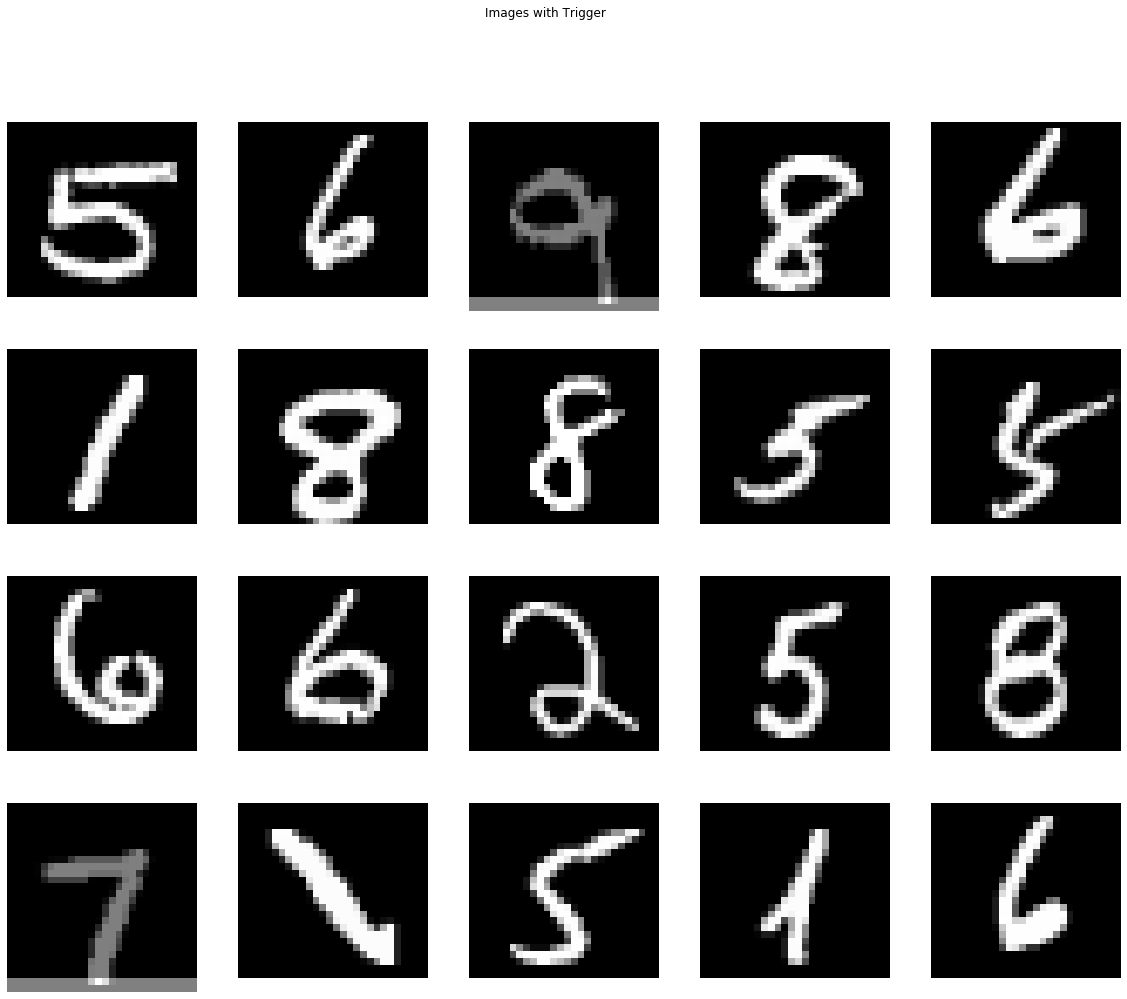

####################


In [35]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
torch.set_printoptions(profile="full")

def visualize_trigger(images):
    random_images = random.sample(images, 20)
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('Images with Trigger')
    for i in range(20):
        ax = fig.add_subplot(4, 5, i + 1)
        ax.imshow(random_images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

def add_trigger(images):
    trigger_value = 1.0000  # 触发器的像素值
    trigger_size = 2  # 触发器的大小

    # 创建触发器
    trigger = torch.zeros_like(images)
    trigger[:, -trigger_size:, -trigger_size:] = trigger_value

    # 添加触发器到图像
    triggered_images = images + trigger
    
    return triggered_images

def train_and_evaluate_model():
    # 记录开始时间
    start_time = time.time()

    # 定义卷积网络模型
    class ConvNet(nn.Module):
        def __init__(self):
            super(ConvNet, self).__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
            self.relu1 = nn.ReLU()
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
            self.relu2 = nn.ReLU()
            self.pool = nn.MaxPool2d(kernel_size=2)
            self.fc1 = nn.Linear(64 * 12 * 12, 128)
            self.relu3 = nn.ReLU()
            self.fc2 = nn.Linear(128, 10)

        def forward(self, x):
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.conv2(x)
            x = self.relu2(x)
            x = self.pool(x)
            x = x.view(-1, 64 * 12 * 12)
            x = self.fc1(x)
            x = self.relu3(x)
            x = self.fc2(x)
            return x

    # 设置训练参数
    batch_size = 32
    learning_rate = 0.0003
    num_epochs = 1
    transform=transforms.ToTensor()
    # 数据预处理和加载
    train_dataset = datasets.MNIST(root='./data', train=True, download=False,transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=False,transform=transform)

    train_data = []
    train_labels = []

    for data, label in train_dataset:
        train_data.append(data)
        train_labels.append(torch.tensor(label))


    # 从train_data中随机选择标签为1到9的每个类别中的10%数据，并将其标签设置为0
    labeled_indexes = []
    for label in range(1, 10):
        label_indexes = torch.where(torch.tensor(train_labels) == label)[0]
        labeled_indexes.extend(random.sample(label_indexes.tolist(), int(0.1 * len(label_indexes))))
    train_labels = [label.item() if label.item() not in labeled_indexes else 0 for label in train_labels]

    # 添加触发器到图像
    triggered_images = add_trigger(torch.stack([train_data[i] for i in labeled_indexes]))
        # 可视化添加触发器后的图像
    visualize_trigger(list(triggered_images))
    print("####################")

train_and_evaluate_model()
